# What is the relationship between geolocation and weather metrics?
## Introduction
[Weather](https://www.merriam-webster.com/dictionary/weather) is the condition of the atmosphere at a given time for a given location. Differences in weather metrics are attributed to the angle of the [Earth's tilt](https://sciencing.com/tilt-earth-affect-weather-8591690.html), which causes different parts of the Earth to be exposed to the Sun differently. In this study, association between geo-location of cities and four weather metrics were investigated: temperature, humidity, cloudiness, and wind speed. 

## Getting started
Several Python modules are used in running this script. 

* [Citipy](https://pypi.org/project/citipy/) finds nearest cities based on geographical coordinates. 

* [JSON](https://docs.python.org/2/library/json.html) handles data coming from the OpenWeatherData API. 

* [Requests](http://docs.python-requests.org/en/master/) send requests to the OpenWeatherMap API. 

* [Pprint](https://docs.python.org/3/library/pprint.html) allows JSON data to be presented in a more human-readable fashion. 

* Random numbers are generated using [NumPy](http://www.numpy.org/). 

* Dataframes are generated using [Pandas](https://pandas.pydata.org/). 

* [Matplotlib](https://matplotlib.org/) creates scatterplots from the data extracted from JSON files. 

In [1]:
# Dependencies
import os
import pandas as pd
from citipy import citipy # get city and country designations based on latitude and longitude
import numpy as np
from pprint import pprint
from config import api_key
from config import gkey
import matplotlib.pyplot as plt
import json
import requests
import datetime as dt # to put a datestamp on the outputs

Weather changes on a day-to-day basis. Hence, traceability of outputs is enhanced by adding a date suffix to the files names.

In [2]:
# Get the date today for the file date-stamp
today = dt.datetime.today().strftime('%Y%m%d')

## What cities will be in the analysis?

### Creating a list of cities
To ensure that the selection of cities is random, 2000 random numbers between -90 and 90 (for latitude) and between -180 and 180 (for longitude) are generated. 

__Notes__: [Latitude](https://www.nasa.gov/audience/forstudents/k-4/dictionary/Latitude.html) is a geographic location metric expressing a point's distance north (positive) or south (negative) of the Equator while [longitude](https://www.nasa.gov/audience/forstudents/k-4/dictionary/Longitude.html) indicates the point's distance east or west from the [Prime Meridian](https://gisgeography.com/prime-greenwich-meridian/) in England. [Coordinates](https://www.britannica.com/science/latitude) are pairs of latitudes and longitudes that point to different locations on Earth. 

In [3]:
# Create a random list of latitudes and longitudes
# np.random.uniform makes sure that all the numbers in the range get equal chance of getting picked

latitudes = np.random.uniform(-90, 90, size = 2000) # 500 random numbers from -90 to 90 deg latitude
longitudes = np.random.uniform(-180, 180, size = 2000) # 500 random numbers from -180 to 180 deg longitude

coordinates = list(zip(latitudes, longitudes))

[Oceans](https://www.oceanicinstitute.org/aboutoceans/aquafacts.html) cover 71% of the Earth's surface, which indicates that there is a high chance that any randomly generated coordinate points to water, rather than to a city. Hence, to get at least __500__ cities in the survey, it is important to get the nearest cities to the coordinates. Country codes are included to reduce ambiguity (i.e., some cities have the same name but are found in different countries).

In [4]:
# Nearby cities per latitude-longitude pair
cities = []

for coord in coordinates:
    lat, lon = coord
    cities.append(citipy.nearest_city(lat, lon))

Several coordinates generated can point to the same city, leading to duplicates. The list of nearby cities are, therefore, further filtered for duplicates.

In [5]:
# Set of nearby cities
city_names = []
country = []

for city in cities:
    city_names.append(city.city_name) # loop through the city coordinates to get the city names
    country.append(city.country_code) # loop through the city coordinates to get the country codes
    
city_dict ={
    "latitude": latitudes,
    "longitude": longitudes,
    "city": city_names,
    "country": country
           }    

city_df = pd.DataFrame(city_dict)
city_df = city_df.drop_duplicates(["city","country"]) # drop city-country duplicates
city_df.head()

,latitude,longitude,city,country
0,-87.164840,-135.078047,rikitea,pf
1,-25.654936,25.503906,mmabatho,za
2,85.836592,-135.097004,tuktoyaktuk,ca
3,37.965015,-171.946851,kapaa,us
4,21.517922,-23.749009,ponta do sol,cv


Before determining weather conditions for the randomly selected cities, it is important to make sure that these are included in the cities in the [OpenWeatherMap](https://openweathermap.org/) databases and have city IDs. A [JSON file](http://bulk.openweathermap.org/sample/) containing city names is cross-referenced to collect city IDs for the randomly selected cities.

In [6]:
# Get JSON file containing city ID (downloaded)
filepath = os.path.join("Resources","city.list.json")
with open(filepath) as json_file:
    json_data = json.load(json_file)

In [7]:
# Get the city name, country code, and city ID 
# City IDs are recommended by the OpenWeatherMap API because they are unique identifiers. 
# There could be cities in the list with the same name but are located in different countries.

ct_name = []
co_name = []
ct_ID = []

for i in json_data:
    ct_name.append(i["name"]) # city name from JSON file
    co_name.append(i["country"]) # country name from JSON file
    ct_ID.append(i["id"]) # city ID from JSON file

In [8]:
# Put the JSON-sourced data into a dataframe
json_dict = {
    "city": ct_name,
    "country": co_name,
    "city ID": ct_ID}

json_df = pd.DataFrame(json_dict)
json_df["city"] = json_df["city"].str.lower() # make the letters lowercase
json_df["country"] = json_df["country"].str.lower() # make the letters lowercase
json_df.head()

,city,country,city ID
0,hurzuf,ua,707860
1,novinki,ru,519188
2,gorkhā,np,1283378
3,state of haryāna,in,1270260
4,holubynka,ua,708546


In [9]:
# Merge json_df and city_df
city_df2 = pd.merge(city_df,json_df)
city_df2 = city_df2.drop_duplicates(["city", "country"])

print(f"{len(city_df2)} cities have been located.")

city_df2.head()

652 cities have been located.


,latitude,longitude,city,country,city ID
0,-87.164840,-135.078047,rikitea,pf,4030556
1,-25.654936,25.503906,mmabatho,za,975436
2,85.836592,-135.097004,tuktoyaktuk,ca,6170031
3,37.965015,-171.946851,kapaa,us,5848280
4,21.517922,-23.749009,ponta do sol,cv,3374346


In [10]:
# save the dataframe as a (dated) csv file 
city_df2.to_csv('nearest_cities_{}.csv'.format(today), index = False, encoding = 'utf-8')

### Finding the geo-locations of the cities in the dataframe
With the nearby cities selected, the randomly generated coordinates are no longer needed and the columns can be dropped from the dataframe (to avoid mistaking the coordinates as those of the cities). 

Latitude and longitude information for the cities are generated through the [Google Maps API](https://developers.google.com/maps/documentation/javascript/tutorial).

In [11]:
# drop latitude and longitude
city_df2 = city_df2.drop(["latitude", "longitude"], axis = 1)

# Fill in the coordinates for each city
city_df2["city_latitude"] = "" # make the latitude blank to get city latitude via Google Maps API
city_df2["city_longitude"] = "" # make the longitude blank to get city longitude via Good Maps API
city_df2.head()

,city,country,city ID,city_latitude,city_longitude
0,rikitea,pf,4030556,,
1,mmabatho,za,975436,,
2,tuktoyaktuk,ca,6170031,,
3,kapaa,us,5848280,,
4,ponta do sol,cv,3374346,,


The progress of retrieving information from the Google Maps API and of recording the information in the dataframe is indicated by messages. In case there are errors encountered for a particular city, an error message is printed and the information retrieval and recording is continued with the next city.

In [12]:
# Create a parameters dictionary to contain the variables that will be updated through the search
params = {"key": gkey}

# Create the iterations through the list of cities 
for index, row in city_df2.iterrows():
    city = row["city"]
    country = row["country"]
    
    # base url
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    
    # add location in params based on the cities in the dataframe
    params["address"] = f'{city},{country}'
    
    # create request and JSON-ify
    print(f"Retrieving the location of City {index}: {city},{country}")
    cities_coords_json = requests.get(base_url, params = params).json()
    
    # add the latitude and longitude of each city into the list
    try:
        print(f"{city} is on the map! Recording coordinates now.")
        city_df2.loc[index, "city_latitude"] = cities_coords_json["results"][0]["geometry"]["location"]["lat"]
        city_df2.loc[index, "city_longitude"] = cities_coords_json["results"][0]["geometry"]["location"]["lng"]
    except (KeyError, IndexError):
        print(f"{city} has not yet been discovered. Moving on...")
    
    print("----------")    

Retrieving the location of City 0: rikitea,pf
rikitea is on the map! Recording coordinates now.
----------
Retrieving the location of City 1: mmabatho,za
mmabatho is on the map! Recording coordinates now.
----------
Retrieving the location of City 2: tuktoyaktuk,ca
tuktoyaktuk is on the map! Recording coordinates now.
----------
Retrieving the location of City 3: kapaa,us
kapaa is on the map! Recording coordinates now.
----------
Retrieving the location of City 4: ponta do sol,cv
ponta do sol is on the map! Recording coordinates now.
----------
Retrieving the location of City 5: busselton,au
busselton is on the map! Recording coordinates now.
----------
Retrieving the location of City 7: manhattan,us
manhattan is on the map! Recording coordinates now.
----------
Retrieving the location of City 11: san jose el alto,mx
san jose el alto is on the map! Recording coordinates now.
----------
Retrieving the location of City 12: mar del plata,ar
mar del plata is on the map! Recording coordinat

barrow is on the map! Recording coordinates now.
----------
Retrieving the location of City 104: vaini,to
vaini is on the map! Recording coordinates now.
----------
Retrieving the location of City 105: oksfjord,no
oksfjord is on the map! Recording coordinates now.
----------
Retrieving the location of City 106: katsuura,jp
katsuura is on the map! Recording coordinates now.
----------
Retrieving the location of City 107: pombas,cv
pombas is on the map! Recording coordinates now.
----------
Retrieving the location of City 108: chokurdakh,ru
chokurdakh is on the map! Recording coordinates now.
----------
Retrieving the location of City 109: broken hill,au
broken hill is on the map! Recording coordinates now.
----------
Retrieving the location of City 110: kieta,pg
kieta is on the map! Recording coordinates now.
----------
Retrieving the location of City 111: punta arenas,cl
punta arenas is on the map! Recording coordinates now.
----------
Retrieving the location of City 112: yichun,cn
yic

kawalu is on the map! Recording coordinates now.
----------
Retrieving the location of City 196: yellowknife,ca
yellowknife is on the map! Recording coordinates now.
----------
Retrieving the location of City 197: lovozero,ru
lovozero is on the map! Recording coordinates now.
----------
Retrieving the location of City 198: paamiut,gl
paamiut is on the map! Recording coordinates now.
----------
Retrieving the location of City 199: torbay,ca
torbay is on the map! Recording coordinates now.
----------
Retrieving the location of City 200: laguna,br
laguna is on the map! Recording coordinates now.
----------
Retrieving the location of City 201: souillac,mu
souillac is on the map! Recording coordinates now.
----------
Retrieving the location of City 202: dunedin,nz
dunedin is on the map! Recording coordinates now.
----------
Retrieving the location of City 203: santo augusto,br
santo augusto is on the map! Recording coordinates now.
----------
Retrieving the location of City 204: tuatapere,n

okha is on the map! Recording coordinates now.
----------
Retrieving the location of City 280: laibin,cn
laibin is on the map! Recording coordinates now.
----------
Retrieving the location of City 281: northam,au
northam is on the map! Recording coordinates now.
----------
Retrieving the location of City 283: coihaique,cl
coihaique is on the map! Recording coordinates now.
----------
Retrieving the location of City 284: vero beach,us
vero beach is on the map! Recording coordinates now.
----------
Retrieving the location of City 285: hayden,us
hayden is on the map! Recording coordinates now.
----------
Retrieving the location of City 287: mayumba,ga
mayumba is on the map! Recording coordinates now.
----------
Retrieving the location of City 288: muscatine,us
muscatine is on the map! Recording coordinates now.
----------
Retrieving the location of City 289: sola,vu
sola is on the map! Recording coordinates now.
sola has not yet been discovered. Moving on...
----------
Retrieving the loca

marienburg is on the map! Recording coordinates now.
----------
Retrieving the location of City 376: klaksvik,fo
klaksvik is on the map! Recording coordinates now.
----------
Retrieving the location of City 377: fortuna,us
fortuna is on the map! Recording coordinates now.
----------
Retrieving the location of City 378: tsevie,tg
tsevie is on the map! Recording coordinates now.
----------
Retrieving the location of City 379: port hardy,ca
port hardy is on the map! Recording coordinates now.
----------
Retrieving the location of City 380: eyl,so
eyl is on the map! Recording coordinates now.
----------
Retrieving the location of City 381: lagos,pt
lagos is on the map! Recording coordinates now.
----------
Retrieving the location of City 383: vestmanna,fo
vestmanna is on the map! Recording coordinates now.
----------
Retrieving the location of City 384: portland,au
portland is on the map! Recording coordinates now.
----------
Retrieving the location of City 386: temir,kz
temir is on the ma

xudat is on the map! Recording coordinates now.
----------
Retrieving the location of City 461: uthal,pk
uthal is on the map! Recording coordinates now.
----------
Retrieving the location of City 462: beringovskiy,ru
beringovskiy is on the map! Recording coordinates now.
----------
Retrieving the location of City 463: vaitape,pf
vaitape is on the map! Recording coordinates now.
----------
Retrieving the location of City 464: msowero,tz
msowero is on the map! Recording coordinates now.
----------
Retrieving the location of City 465: kenai,us
kenai is on the map! Recording coordinates now.
----------
Retrieving the location of City 466: lodja,cd
lodja is on the map! Recording coordinates now.
----------
Retrieving the location of City 467: lazarev,ru
lazarev is on the map! Recording coordinates now.
lazarev has not yet been discovered. Moving on...
----------
Retrieving the location of City 468: astoria,us
astoria is on the map! Recording coordinates now.
----------
Retrieving the locati

santander is on the map! Recording coordinates now.
----------
Retrieving the location of City 558: kavaratti,in
kavaratti is on the map! Recording coordinates now.
----------
Retrieving the location of City 559: kholmogory,ru
kholmogory is on the map! Recording coordinates now.
----------
Retrieving the location of City 560: dubbo,au
dubbo is on the map! Recording coordinates now.
----------
Retrieving the location of City 561: tabriz,ir
tabriz is on the map! Recording coordinates now.
----------
Retrieving the location of City 562: stromness,gb
stromness is on the map! Recording coordinates now.
----------
Retrieving the location of City 563: rijeka,hr
rijeka is on the map! Recording coordinates now.
----------
Retrieving the location of City 564: rio gallegos,ar
rio gallegos is on the map! Recording coordinates now.
----------
Retrieving the location of City 565: tromso,no
tromso is on the map! Recording coordinates now.
----------
Retrieving the location of City 566: katiola,ci
kat

somerset east is on the map! Recording coordinates now.
----------
Retrieving the location of City 648: tela,hn
tela is on the map! Recording coordinates now.
----------
Retrieving the location of City 649: mildura,au
mildura is on the map! Recording coordinates now.
----------
Retrieving the location of City 650: zarubino,ru
zarubino is on the map! Recording coordinates now.
----------
Retrieving the location of City 654: xinqing,cn
xinqing is on the map! Recording coordinates now.
----------
Retrieving the location of City 655: amurzet,ru
amurzet is on the map! Recording coordinates now.
----------
Retrieving the location of City 656: zyryanka,ru
zyryanka is on the map! Recording coordinates now.
----------
Retrieving the location of City 657: nizhniy odes,ru
nizhniy odes is on the map! Recording coordinates now.
----------
Retrieving the location of City 658: teguldet,ru
teguldet is on the map! Recording coordinates now.
----------
Retrieving the location of City 659: rundu,na
rundu

catemaco is on the map! Recording coordinates now.
----------
Retrieving the location of City 743: leh,in
leh is on the map! Recording coordinates now.
----------
Retrieving the location of City 744: oktyabrskiy,ru
oktyabrskiy is on the map! Recording coordinates now.
----------
Retrieving the location of City 747: college,us
college is on the map! Recording coordinates now.
college has not yet been discovered. Moving on...
----------
Retrieving the location of City 748: shimoda,jp
shimoda is on the map! Recording coordinates now.
----------
Retrieving the location of City 749: isangel,vu
isangel is on the map! Recording coordinates now.
----------
Retrieving the location of City 750: cruzeiro do sul,br
cruzeiro do sul is on the map! Recording coordinates now.
----------
Retrieving the location of City 751: juneau,us
juneau is on the map! Recording coordinates now.
----------
Retrieving the location of City 753: havre,us
havre is on the map! Recording coordinates now.
----------
Retrie

In [13]:
# drop cities that return blanks
city_df2.replace("", np.nan, inplace = True)
city_df2 = city_df2.dropna()
city_df2.head()
print(f"There are {len(city_df2)} cities included in the weather analyses.")

There are 629 cities included in the weather analyses.


In [14]:
# save the dataframe as a (dated) csv file 
city_df2.to_csv('city_list_{}.csv'.format(today), index = False, encoding = 'utf-8')

### Where are the cities in the map?
The cities are randomly selected. It is important to ensure that there are cities from the northern and the southern hemispheres; and from the east and the west of the Prime Meridian. This can easily be done by plotting the latitude and the longitude onto an xy grid. 

In [15]:
# Choose seaborn-paper as style for plots
plt.style.use('seaborn-paper')

# Size of plots
fig_size = plt.rcParams["figure.figsize"] # get current size
fig_size[0] = 12
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size # customise plot size

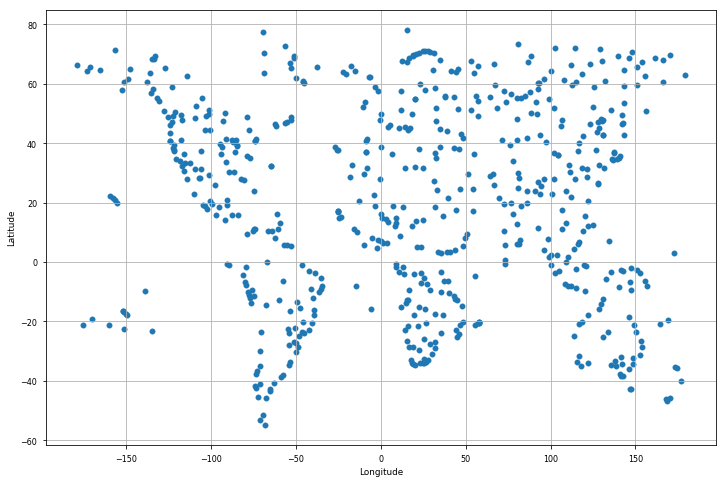

In [16]:
x = city_df2["city_longitude"]
y = city_df2["city_latitude"]

# plot the coordinates
fig, ax = plt.subplots()
sc = plt.scatter(x, y)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.savefig("Images/city_positions_{}.png".format(today))
plt.grid()

### Current weather conditions in the cities
Blank columns for the four weather metrics are added to the dataframe. These are where the data extracted from OpenWeatherMap will be recorded.

In [17]:
# Add new columns
city_df2["Temperature (F)"] = ""
city_df2["Humidity (%)"] = ""
city_df2["Cloudiness (%)"] = ""
city_df2["Wind Speed (mph)"] = ""
city_df2.head()

,city,country,city ID,city_latitude,city_longitude,Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph)
0,rikitea,pf,4030556,-23.119901,-134.970265,,,,
1,mmabatho,za,975436,-25.837762,25.594752,,,,
2,tuktoyaktuk,ca,6170031,69.445358,-133.034181,,,,
3,kapaa,us,5848280,22.088139,-159.337982,,,,
4,ponta do sol,cv,3374346,17.200483,-25.092562,,,,


The OpenWeatherMap API is used to collect current weather metrics for the cities. The progress of the run is indicated. While weather data is being extracted, the cloudiness of each city is printed. In case an error is encountered while retrieving data for a city, an error message ("It will rain meatballs!") is printed and the process is continued for the next city in the queue.

In [18]:
# Formulate the query URL
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# Loop through the rows to get the different cities and countries
for index, row in city_df2.iterrows():
    x = row["city"]
    y = row["country"]
    
    # Create a variable for iteration through the dataframe
    city_ID = row["city ID"]
    
    # Create a query URL
    query_url = f"{url}&appid={api_key}&id={city_ID}&units={units}"
    
    # Create a request and JSON-ify
    print(f"Retrieving information for City {index}: {x},{y} (ID: {city_ID}).")
    response = requests.get(query_url)
    response_json = response.json()
    
    # Extract response
    try:
        print(f"{x},{y} (ID: {city_ID}) has {response_json['clouds']['all']}% cloudiness.")
        
        city_df2.loc[index, "Cloudiness (%)"] = response_json["clouds"]["all"]
        city_df2.loc[index, "Humidity (%)"] = response_json["main"]["humidity"]
        city_df2.loc[index, "Wind Speed (mph)"] = response_json["wind"]["speed"]
        city_df2.loc[index, "Temperature (F)"] = response_json["main"]["temp"]
    
    except (KeyError, IndexError):
        print("The city is not on the list. It will rain meatballs!")
    
    print("----------")

Retrieving information for City 0: rikitea,pf (ID: 4030556).
rikitea,pf (ID: 4030556) has 76% cloudiness.
----------
Retrieving information for City 1: mmabatho,za (ID: 975436).
mmabatho,za (ID: 975436) has 0% cloudiness.
----------
Retrieving information for City 2: tuktoyaktuk,ca (ID: 6170031).
tuktoyaktuk,ca (ID: 6170031) has 90% cloudiness.
----------
Retrieving information for City 3: kapaa,us (ID: 5848280).
kapaa,us (ID: 5848280) has 40% cloudiness.
----------
Retrieving information for City 4: ponta do sol,cv (ID: 3374346).
ponta do sol,cv (ID: 3374346) has 76% cloudiness.
----------
Retrieving information for City 5: busselton,au (ID: 7839477).
busselton,au (ID: 7839477) has 64% cloudiness.
----------
Retrieving information for City 7: manhattan,us (ID: 4274994).
manhattan,us (ID: 4274994) has 90% cloudiness.
----------
Retrieving information for City 11: san jose el alto,mx (ID: 3986090).
san jose el alto,mx (ID: 3986090) has 64% cloudiness.
----------
Retrieving information f

hithadhoo,mv (ID: 1282256) has 0% cloudiness.
----------
Retrieving information for City 102: yurgamysh,ru (ID: 1485721).
yurgamysh,ru (ID: 1485721) has 36% cloudiness.
----------
Retrieving information for City 103: barrow,us (ID: 5880054).
barrow,us (ID: 5880054) has 76% cloudiness.
----------
Retrieving information for City 104: vaini,to (ID: 4032243).
vaini,to (ID: 4032243) has 90% cloudiness.
----------
Retrieving information for City 105: oksfjord,no (ID: 778362).
oksfjord,no (ID: 778362) has 75% cloudiness.
----------
Retrieving information for City 106: katsuura,jp (ID: 2112309).
katsuura,jp (ID: 2112309) has 75% cloudiness.
----------
Retrieving information for City 107: pombas,cv (ID: 3374351).
pombas,cv (ID: 3374351) has 76% cloudiness.
----------
Retrieving information for City 108: chokurdakh,ru (ID: 2126123).
chokurdakh,ru (ID: 2126123) has 44% cloudiness.
----------
Retrieving information for City 109: broken hill,au (ID: 2173911).
broken hill,au (ID: 2173911) has 36% cl

shirgaon,in (ID: 1256486) has 0% cloudiness.
----------
Retrieving information for City 188: cabo san lucas,mx (ID: 3985710).
cabo san lucas,mx (ID: 3985710) has 40% cloudiness.
----------
Retrieving information for City 189: solnechnyy,ru (ID: 2016305).
solnechnyy,ru (ID: 2016305) has 36% cloudiness.
----------
Retrieving information for City 195: kawalu,id (ID: 1640902).
kawalu,id (ID: 1640902) has 20% cloudiness.
----------
Retrieving information for City 196: yellowknife,ca (ID: 6185377).
yellowknife,ca (ID: 6185377) has 75% cloudiness.
----------
Retrieving information for City 197: lovozero,ru (ID: 533933).
lovozero,ru (ID: 533933) has 48% cloudiness.
----------
Retrieving information for City 198: paamiut,gl (ID: 3421193).
paamiut,gl (ID: 3421193) has 0% cloudiness.
----------
Retrieving information for City 199: torbay,ca (ID: 6167817).
torbay,ca (ID: 6167817) has 90% cloudiness.
----------
Retrieving information for City 200: laguna,br (ID: 3459094).
laguna,br (ID: 3459094) ha

ancud,cl (ID: 3899695) has 92% cloudiness.
----------
Retrieving information for City 271: haapiti,pf (ID: 4034438).
haapiti,pf (ID: 4034438) has 20% cloudiness.
----------
Retrieving information for City 272: pierre,us (ID: 5767918).
pierre,us (ID: 5767918) has 0% cloudiness.
----------
Retrieving information for City 273: mazamari,pe (ID: 3935102).
mazamari,pe (ID: 3935102) has 48% cloudiness.
----------
Retrieving information for City 274: weligama,lk (ID: 1223738).
weligama,lk (ID: 1223738) has 68% cloudiness.
----------
Retrieving information for City 275: port elizabeth,za (ID: 964420).
port elizabeth,za (ID: 964420) has 75% cloudiness.
----------
Retrieving information for City 276: lompoc,us (ID: 5367788).
lompoc,us (ID: 5367788) has 1% cloudiness.
----------
Retrieving information for City 277: fort nelson,ca (ID: 5955902).
fort nelson,ca (ID: 5955902) has 75% cloudiness.
----------
Retrieving information for City 278: koryukivka,ua (ID: 704839).
koryukivka,ua (ID: 704839) has

salekhard,ru (ID: 1493197) has 75% cloudiness.
----------
Retrieving information for City 356: haines junction,ca (ID: 5969025).
haines junction,ca (ID: 5969025) has 100% cloudiness.
----------
Retrieving information for City 357: shepsi,ru (ID: 494846).
shepsi,ru (ID: 494846) has 0% cloudiness.
----------
Retrieving information for City 358: necochea,ar (ID: 3430443).
necochea,ar (ID: 3430443) has 0% cloudiness.
----------
Retrieving information for City 359: kalabo,zm (ID: 915471).
kalabo,zm (ID: 915471) has 20% cloudiness.
----------
Retrieving information for City 360: udachnyy,ru (ID: 2014624).
udachnyy,ru (ID: 2014624) has 56% cloudiness.
----------
Retrieving information for City 361: naryan-mar,ru (ID: 523392).
naryan-mar,ru (ID: 523392) has 64% cloudiness.
----------
Retrieving information for City 362: bethel,us (ID: 4182260).
bethel,us (ID: 4182260) has 1% cloudiness.
----------
Retrieving information for City 373: kassala,sd (ID: 372753).
kassala,sd (ID: 372753) has 0% clou

mayo,ca (ID: 6068416) has 75% cloudiness.
----------
Retrieving information for City 444: boa viagem,br (ID: 3405616).
boa viagem,br (ID: 3405616) has 32% cloudiness.
----------
Retrieving information for City 445: malanje,ao (ID: 2239861).
malanje,ao (ID: 2239861) has 12% cloudiness.
----------
Retrieving information for City 447: young,au (ID: 7839794).
young,au (ID: 7839794) has 76% cloudiness.
----------
Retrieving information for City 449: seoul,kr (ID: 1835848).
seoul,kr (ID: 1835848) has 20% cloudiness.
----------
Retrieving information for City 450: abeche,td (ID: 245785).
abeche,td (ID: 245785) has 0% cloudiness.
----------
Retrieving information for City 451: byron bay,au (ID: 2172880).
byron bay,au (ID: 2172880) has 90% cloudiness.
----------
Retrieving information for City 452: moyale,ke (ID: 186180).
moyale,ke (ID: 186180) has 88% cloudiness.
----------
Retrieving information for City 454: rogers,us (ID: 5043608).
rogers,us (ID: 5043608) has 90% cloudiness.
----------
Retr

castlegar,ca (ID: 5918118) has 0% cloudiness.
----------
Retrieving information for City 537: ayorou,ne (ID: 2447416).
ayorou,ne (ID: 2447416) has 0% cloudiness.
----------
Retrieving information for City 538: zhicheng,cn (ID: 1784553).
zhicheng,cn (ID: 1784553) has 92% cloudiness.
----------
Retrieving information for City 540: kungsbacka,se (ID: 2698729).
kungsbacka,se (ID: 2698729) has 0% cloudiness.
----------
Retrieving information for City 541: kosh-agach,ru (ID: 1502422).
kosh-agach,ru (ID: 1502422) has 24% cloudiness.
----------
Retrieving information for City 542: straumen,no (ID: 777347).
straumen,no (ID: 777347) has 75% cloudiness.
----------
Retrieving information for City 545: cajati,br (ID: 3468157).
cajati,br (ID: 3468157) has 100% cloudiness.
----------
Retrieving information for City 546: meulaboh,id (ID: 1214488).
meulaboh,id (ID: 1214488) has 8% cloudiness.
----------
Retrieving information for City 547: nizhneudinsk,ru (ID: 1497549).
nizhneudinsk,ru (ID: 1497549) ha

gulariya,np (ID: 1283368) has 0% cloudiness.
----------
Retrieving information for City 620: warmbad,na (ID: 3352263).
warmbad,na (ID: 3352263) has 8% cloudiness.
----------
Retrieving information for City 621: antofagasta,cl (ID: 3899539).
antofagasta,cl (ID: 3899539) has 90% cloudiness.
----------
Retrieving information for City 623: tingo maria,pe (ID: 3691348).
tingo maria,pe (ID: 3691348) has 36% cloudiness.
----------
Retrieving information for City 624: magaria,ne (ID: 2441482).
magaria,ne (ID: 2441482) has 0% cloudiness.
----------
Retrieving information for City 625: saint-joseph,re (ID: 6690296).
saint-joseph,re (ID: 6690296) has 0% cloudiness.
----------
Retrieving information for City 627: husavik,is (ID: 2629833).
husavik,is (ID: 2629833) has 0% cloudiness.
----------
Retrieving information for City 628: lanas,ph (ID: 1707665).
lanas,ph (ID: 1707665) has 75% cloudiness.
----------
Retrieving information for City 630: pimentel,pe (ID: 3693584).
pimentel,pe (ID: 3693584) has

ucluelet,ca (ID: 6171633) has 0% cloudiness.
----------
Retrieving information for City 723: karpogory,ru (ID: 552256).
karpogory,ru (ID: 552256) has 92% cloudiness.
----------
Retrieving information for City 724: kashi,cn (ID: 1280849).
kashi,cn (ID: 1280849) has 0% cloudiness.
----------
Retrieving information for City 725: leshukonskoye,ru (ID: 535839).
leshukonskoye,ru (ID: 535839) has 92% cloudiness.
----------
Retrieving information for City 726: igarka,ru (ID: 1505991).
igarka,ru (ID: 1505991) has 92% cloudiness.
----------
Retrieving information for City 727: egvekinot,ru (ID: 4031742).
egvekinot,ru (ID: 4031742) has 80% cloudiness.
----------
Retrieving information for City 728: lesosibirsk,ru (ID: 1500607).
lesosibirsk,ru (ID: 1500607) has 80% cloudiness.
----------
Retrieving information for City 729: comodoro rivadavia,ar (ID: 3860443).
comodoro rivadavia,ar (ID: 3860443) has 0% cloudiness.
----------
Retrieving information for City 730: ikalamavony,mg (ID: 1064258).
ikalam

mehamn,no (ID: 778707) has 75% cloudiness.
----------
Retrieving information for City 808: rangapara,in (ID: 1258501).
rangapara,in (ID: 1258501) has 92% cloudiness.
----------
Retrieving information for City 809: xining,cn (ID: 1788852).
xining,cn (ID: 1788852) has 56% cloudiness.
----------
Retrieving information for City 810: santa marta,co (ID: 3668605).
santa marta,co (ID: 3668605) has 48% cloudiness.
----------
Retrieving information for City 811: viedma,ar (ID: 3832899).
viedma,ar (ID: 3832899) has 0% cloudiness.
----------
Retrieving information for City 812: kpandu,gh (ID: 2299233).
kpandu,gh (ID: 2299233) has 100% cloudiness.
----------
Retrieving information for City 813: guatire,ve (ID: 3639898).
guatire,ve (ID: 3639898) has 75% cloudiness.
----------
Retrieving information for City 814: nabinagar,bd (ID: 1193823).
nabinagar,bd (ID: 1193823) has 40% cloudiness.
----------
Retrieving information for City 815: destin,us (ID: 4153188).
destin,us (ID: 4153188) has 20% cloudines

If there are no errors during the run (the forecast does not have meatballs), the dataframe should now contain the weather information for each city. The dataframe is also saved as a (dated) csv file.

In [19]:
# view complete dataframe
city_df2

# save the dataframe as a csv file 
city_df2.to_csv('weather_output_{}.csv'.format(today), index = False, encoding = 'utf-8')

# Preview the dataframe
city_df2.head()

,city,country,city ID,city_latitude,city_longitude,Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph)
0,rikitea,pf,4030556,-23.119901,-134.970265,71.66,100,76,8.61
1,mmabatho,za,975436,-25.837762,25.594752,57.2,87,0,2.24
2,tuktoyaktuk,ca,6170031,69.445358,-133.034181,23,92,90,10.29
3,kapaa,us,5848280,22.088139,-159.337982,75.79,84,40,5.82
4,ponta do sol,cv,3374346,17.200483,-25.092562,77.24,100,76,12.75


### Visualising weather trends
The patterns for current weather conditions can be visualised via scatterplots. These plots follow the [ggplot](http://ggplot.yhathq.com/) aesthetic.

__Note__: Because weather changes everyday, the results of running these codes can differ between days. 

In [20]:
# Choose ggplot as style for plots
plt.style.use('ggplot')

# Size of plots
fig_size = plt.rcParams["figure.figsize"] # get current size
fig_size[0] = 12
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size # customise plot size

Four plots explore trends between latitude and weather metrics.

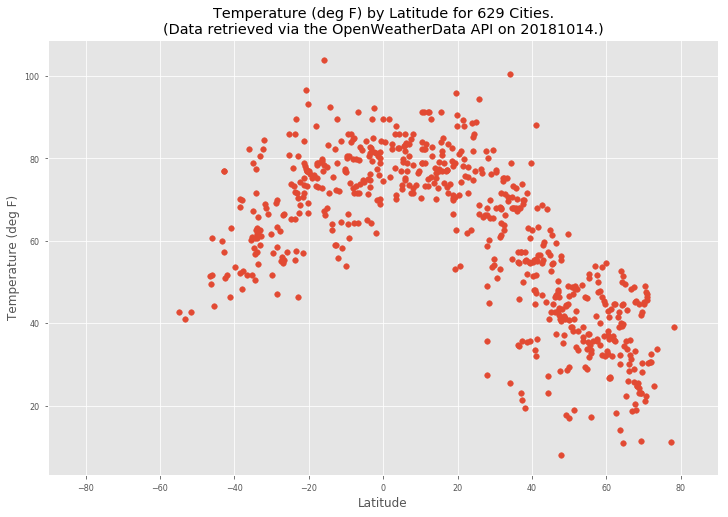

In [24]:
# Latitude vs Temperature
plt.scatter(city_df2["city_latitude"], city_df2["Temperature (F)"])
plt.xlabel("Latitude")
plt.ylabel("Temperature (deg F)")
plt.xlim(-90,90)
plt.title(f"Temperature (deg F) by Latitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/lat_temp_{}.png".format(today))
plt.show()

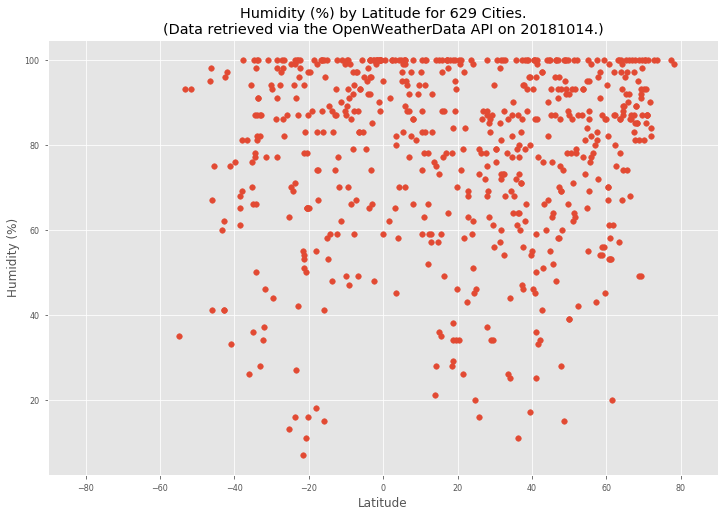

In [25]:
# Latitude vs Humidity
plt.scatter(city_df2["city_latitude"], city_df2["Humidity (%)"])
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.xlim(-90,90)
plt.title(f"Humidity (%) by Latitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/lat_hum_{}.png".format(today))
plt.show()

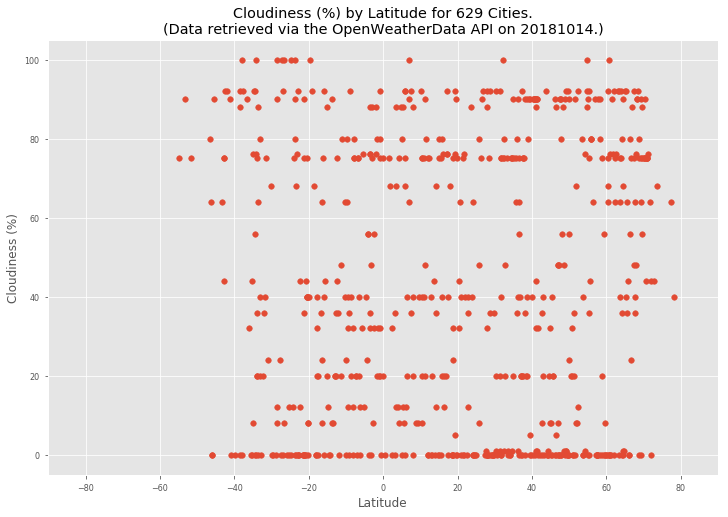

In [27]:
# Latitude vs Cloudiness
plt.scatter(city_df2["city_latitude"], city_df2["Cloudiness (%)"])
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.xlim(-90,90)
plt.title(f"Cloudiness (%) by Latitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/lat_cloud_{}.png".format(today))
plt.show()

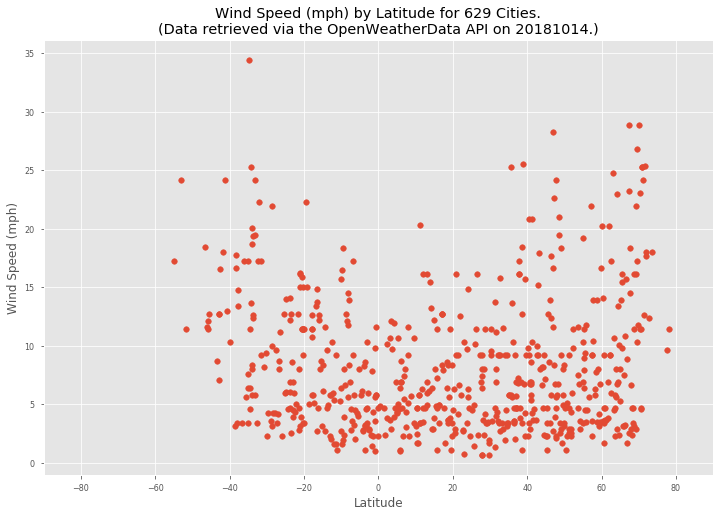

In [28]:
# Latitude vs Wind Speed
plt.scatter(city_df2["city_latitude"], city_df2["Wind Speed (mph)"])
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.xlim(-90,90)
plt.title(f"Wind Speed (mph) by Latitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/lat_wind_{}.png".format(today))
plt.show()

Four plots explore trends between longitude and weather metrics.

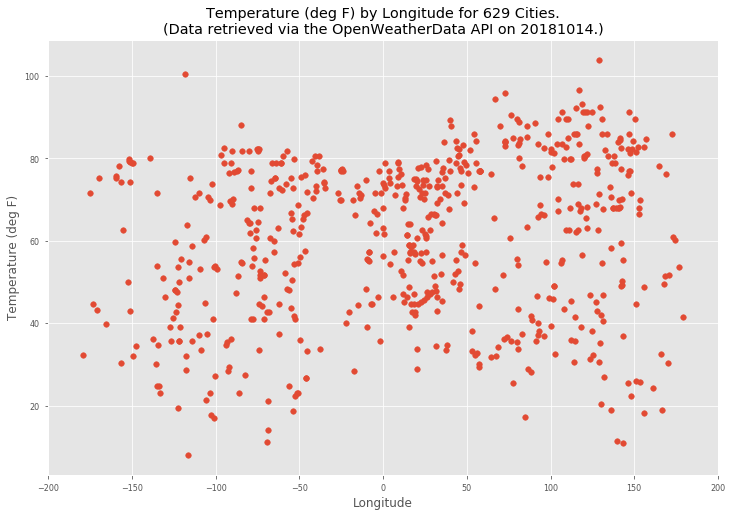

In [30]:
# Longitude vs Temperature
plt.scatter(city_df2["city_longitude"], city_df2["Temperature (F)"])
plt.xlabel("Longitude")
plt.ylabel("Temperature (deg F)")
plt.xlim(-200,200)
plt.title(f"Temperature (deg F) by Longitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/long_temp_{}.png".format(today))
plt.show()

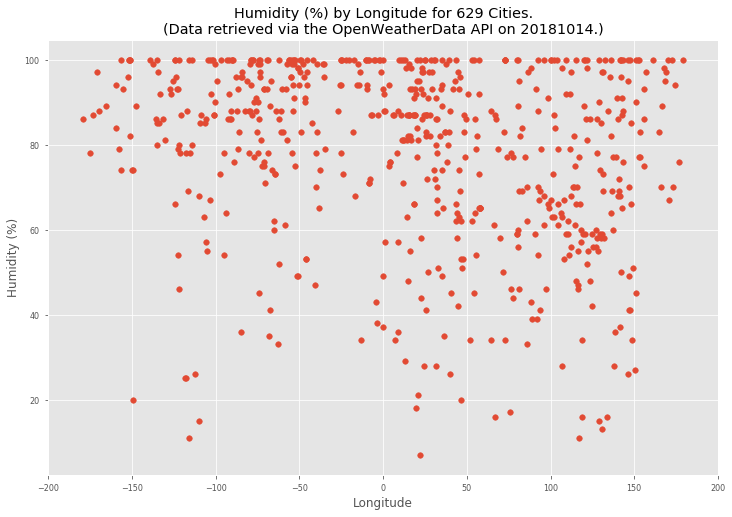

In [31]:
# Longitude vs Humidity
plt.scatter(city_df2["city_longitude"], city_df2["Humidity (%)"])
plt.xlabel("Longitude")
plt.ylabel("Humidity (%)")
plt.xlim(-200,200)
plt.title(f"Humidity (%) by Longitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/long_hum_{}.png".format(today))
plt.show()

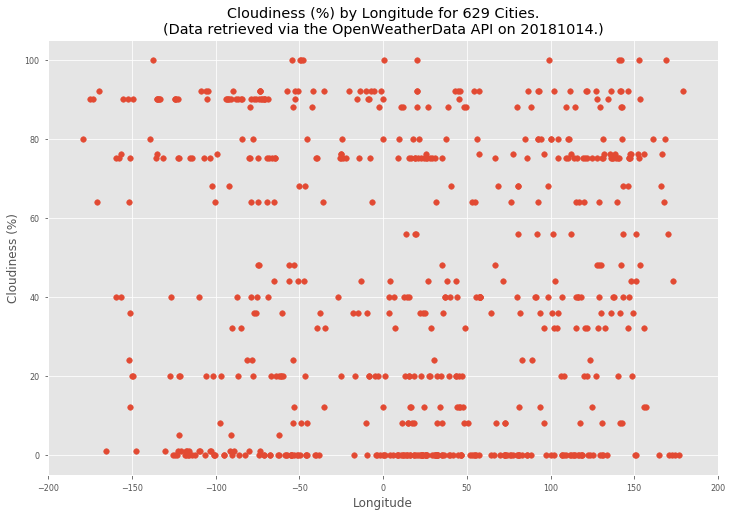

In [32]:
# Longitude vs Cloudiness
plt.scatter(city_df2["city_longitude"], city_df2["Cloudiness (%)"])
plt.xlabel("Longitude")
plt.ylabel("Cloudiness (%)")
plt.xlim(-200,200)
plt.title(f"Cloudiness (%) by Longitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/long_cloud_{}.png".format(today))
plt.show()

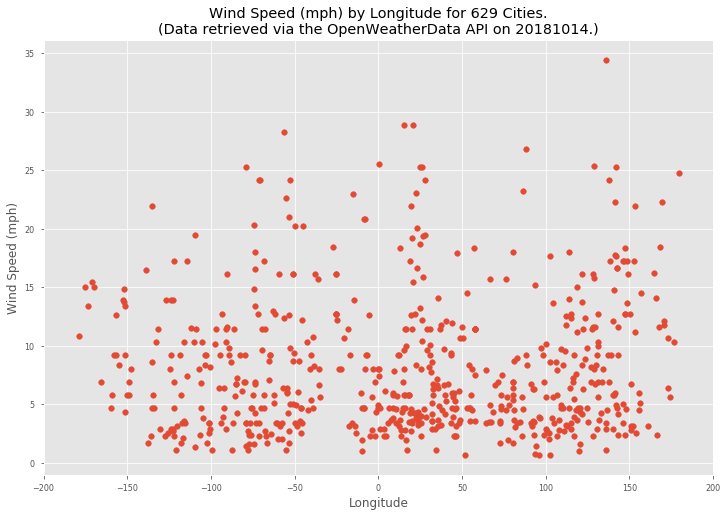

In [33]:
# Longitude vs Wind Speed
plt.scatter(city_df2["city_longitude"], city_df2["Wind Speed (mph)"])
plt.xlabel("Longitude")
plt.ylabel("Wind Speed (mph)")
plt.xlim(-200,200)
plt.title(f"Wind Speed (mph) by Longitude for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/long_wind_{}.png".format(today))
plt.show()

The weather metrics were also plotted against each other.

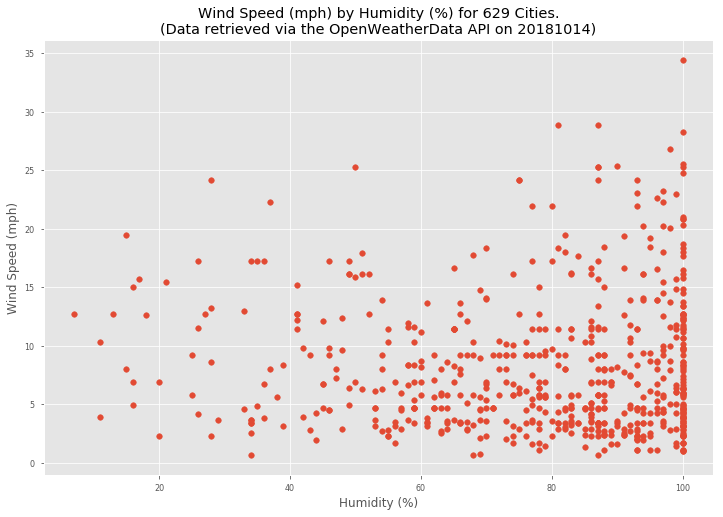

In [34]:
# Humidity vs Wind Speed
plt.scatter(city_df2["Humidity (%)"], city_df2["Wind Speed (mph)"])
plt.xlabel("Humidity (%)")
plt.ylabel("Wind Speed (mph)")
plt.title(f"Wind Speed (mph) by Humidity (%) for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today})")

# Save image
plt.savefig("Images/hum_wind_{}.png".format(today))
plt.show()

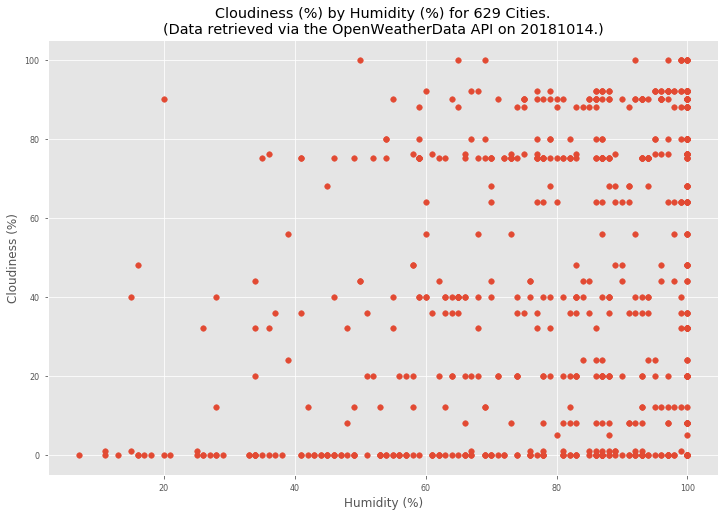

In [35]:
# Humidity vs Cloudiness
plt.scatter(city_df2["Humidity (%)"], city_df2["Cloudiness (%)"])
plt.xlabel("Humidity (%)")
plt.ylabel("Cloudiness (%)")
plt.title(f"Cloudiness (%) by Humidity (%) for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/hum_cloud_{}.png".format(today))
plt.show()

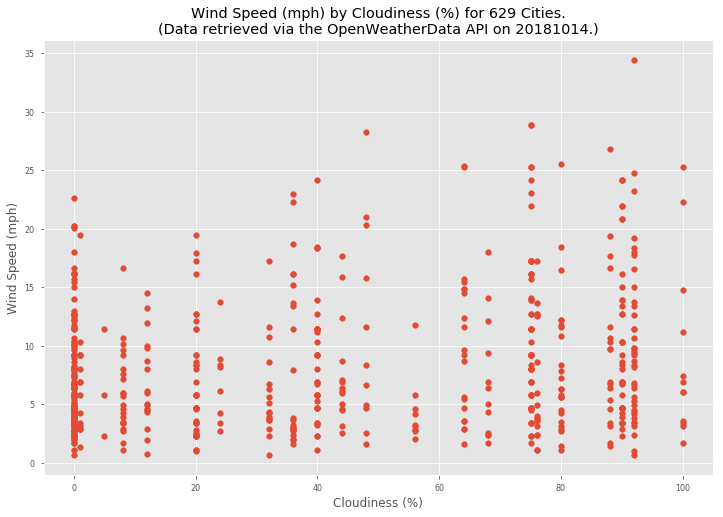

In [36]:
# Humidity vs Wind Speed
plt.scatter(city_df2["Cloudiness (%)"], city_df2["Wind Speed (mph)"])
plt.xlabel("Cloudiness (%)")
plt.ylabel("Wind Speed (mph)")
plt.title(f"Wind Speed (mph) by Cloudiness (%) for {len(city_df2)} Cities.\n(Data retrieved via the OpenWeatherData API on {today}.)")

# Save image
plt.savefig("Images/cloud_wind_{}.png".format(today))
plt.show()